In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT

from lib.Extractor import FeatureExtractor
from lib.Models import FullyConnectedNetworkClassifier
from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, CategoricalTargetTransformer, DatasetTransformer

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

In [2]:
print(sklearn.__version__), print(np.__version__)

0.23.2
1.19.1


(None, None)

##### Reproducibility

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Whole training set

In [3]:
whole_train_df = pd.read_csv('train.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False, low_memory=False)
print('{0:,} registros a las {1}'.format(len(whole_train_df), datetime.now()))
whole_train_df.head()

180,761 registros a las 2020-09-13 15:26:19.751266


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


### Training and Validation set's split

In [5]:
train_data = []
validation_data = []

for row in whole_train_df.itertuples(index=False):
    if abs(hash(row.item_id)) % 10 < 2: 
        validation_data.append(row)
    else:
        train_data.append(row)
        
train_df = pd.DataFrame(data=train_data, columns=whole_train_df.columns)
validation_df = pd.DataFrame(data=validation_data, columns=whole_train_df.columns)

In [3]:
train_df.to_csv('_train_2020_09_13.csv', index=False)
validation_df.to_csv('_validation_2020_09_13.csv', index=False)

NameError: name 'train_df' is not defined

In [3]:
train_df = pd.read_csv('_train_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

144,995 registros a las 2020-09-15 19:55:08.069703


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [5]:
train_df.dtypes

accepts_mercadopago                     bool
available_quantity                     int64
avg_gmv_item_domain_30days           float64
avg_gmv_item_sel                     float64
avg_gmv_seller_bday                  float64
avg_qty_orders_item_domain_30days    float64
avg_qty_orders_item_sel_30days       float64
avg_si_item_sel_30day                float64
benefit                              float64
boosted                                 bool
category_id                           object
conversion                              bool
date                                  object
deal_print_id                         object
domain_id                             object
etl_version                           object
free_shipping                           bool
fulfillment                             bool
full_name                             object
health                               float64
is_pdp                                object
product_id                           float64
item_id   

In [6]:
train_df.isna().sum()

accepts_mercadopago                       0
available_quantity                        0
avg_gmv_item_domain_30days             3149
avg_gmv_item_sel                       3149
avg_gmv_seller_bday                    3149
avg_qty_orders_item_domain_30days      3149
avg_qty_orders_item_sel_30days         3149
avg_si_item_sel_30day                  3149
benefit                                   1
boosted                                   0
category_id                               0
conversion                                0
date                                      0
deal_print_id                             0
domain_id                                 0
etl_version                               0
free_shipping                             0
fulfillment                               0
full_name                                 0
health                                    0
is_pdp                                65323
product_id                           110858
item_id                         

In [4]:
validation_df = pd.read_csv('_validation_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(validation_df), datetime.now()))
validation_df.head()

35,766 registros a las 2020-09-15 19:55:15.034963


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,6,280.245759,508.898157,19880.954667,3.340348,7.337031,8.120307,0.001,False,...,8599.0,18979.0,120.0,9517.0,1919367,19627,375891,7a81b3dc-0f1d-47b9-9ebe-6b080f0f9a78,43543000.0,GARANTIA DEL FABRICANTE 12 MESES
1,True,44,114.704700,200.589045,2239.911000,4.387991,2.588060,3.023881,0.001,False,...,867.0,5279.0,4.0,1013.0,336447,243,202158,ede61a11-5ef8-4626-86d0-2040abcb15d3,NaN,NaN
2,True,163,69.938155,120.521127,4917.262000,2.836291,4.301471,7.982026,0.001,False,...,5265.0,16769.0,90.0,9770.0,293809,1514,134501,37695e18-617e-4977-9d8d-25b963bcbfda,158491483.0,Garantía del vendedor: 15 días
3,True,99980,61.344055,43.361379,335.328000,5.504259,5.172414,12.599138,0.001,False,...,1200.0,8458.0,18.0,2923.0,98151,207,81713,6177b855-73f4-454b-92a6-84ab2870ba56,195821718.0,Garantía del vendedor: 180 días
4,True,3741,275.396775,5019.725800,8366.209667,3.506554,124.760000,139.820000,0.001,False,...,6238.0,15074.0,219.0,6991.0,1612203,21461,503854,b80c6195-ae11-4980-81a2-0b6af863abd3,322103542.0,Garantía del vendedor: 6 meses


In [8]:
validation_df.dtypes

accepts_mercadopago                     bool
available_quantity                     int64
avg_gmv_item_domain_30days           float64
avg_gmv_item_sel                     float64
avg_gmv_seller_bday                  float64
avg_qty_orders_item_domain_30days    float64
avg_qty_orders_item_sel_30days       float64
avg_si_item_sel_30day                float64
benefit                              float64
boosted                                 bool
category_id                           object
conversion                              bool
date                                  object
deal_print_id                         object
domain_id                             object
etl_version                           object
free_shipping                           bool
fulfillment                             bool
full_name                             object
health                               float64
is_pdp                                object
product_id                           float64
item_id   

In [9]:
validation_df.isna().sum()

accepts_mercadopago                      0
available_quantity                       0
avg_gmv_item_domain_30days             775
avg_gmv_item_sel                       775
avg_gmv_seller_bday                    775
avg_qty_orders_item_domain_30days      775
avg_qty_orders_item_sel_30days         775
avg_si_item_sel_30day                  775
benefit                                  0
boosted                                  0
category_id                              0
conversion                               0
date                                     0
deal_print_id                            0
domain_id                                0
etl_version                              0
free_shipping                            0
fulfillment                              0
full_name                                0
health                                   0
is_pdp                               15943
product_id                           27004
item_id                                  0
listing_typ

### Test set

In [5]:
test_df = pd.read_csv('test.csv', sep=',')
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-15 19:55:22.510623


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


In [11]:
test_df.dtypes

accepts_mercadopago                     bool
available_quantity                     int64
avg_gmv_item_domain_30days           float64
avg_gmv_item_sel                     float64
avg_gmv_seller_bday                  float64
avg_qty_orders_item_domain_30days    float64
avg_qty_orders_item_sel_30days       float64
avg_si_item_sel_30day                float64
benefit                              float64
boosted                                 bool
category_id                           object
date                                  object
deal_print_id                         object
domain_id                             object
etl_version                           object
free_shipping                           bool
fulfillment                             bool
full_name                             object
health                               float64
is_pdp                                object
product_id                           float64
item_id                               object
listing_ty

In [12]:
test_df.isna().sum()

accepts_mercadopago                      0
available_quantity                       0
avg_gmv_item_domain_30days             441
avg_gmv_item_sel                       441
avg_gmv_seller_bday                    441
avg_qty_orders_item_domain_30days      441
avg_qty_orders_item_sel_30days         441
avg_si_item_sel_30day                  441
benefit                                  0
boosted                                  0
category_id                              0
date                                     0
deal_print_id                            0
domain_id                                0
etl_version                              0
free_shipping                            0
fulfillment                              0
full_name                                0
health                                   0
is_pdp                                8918
product_id                           14500
item_id                                  0
listing_type_id                          0
logistic_ty

### To dictionaries

In [6]:
X_train = train_df.to_dict('records')
X_validation = validation_df.to_dict('records')
X_test = test_df.to_dict('records')

Y_train = train_df['conversion'].values
Y_validation = validation_df['conversion'].values

In [9]:
test_transformer = CategoricalTransformer(feature='date', pre_tms=[FT(get_day_of_week)])
data_train = np.array([record['date'] for record in X_train]) 
data_validation = np.array([record['date'] for record in X_validation])
data_test = np.array([record['date'] for record in X_test])

In [25]:
data_train[:10], data_train.dtype

(array(['2020-03-06', '2020-04-01', '2020-04-08', '2020-04-25',
        '2020-03-10', '2020-03-02', '2020-04-25', '2020-03-18',
        '2020-04-25', '2020-03-14'], dtype='<U10'),
 dtype('<U10'))

In [ ]:
np.unique(data_train)

In [ ]:
data_validation[:10], data_train.dtype

In [ ]:
np.unique(data_validation)

In [ ]:
data_test[:10], data_test.dtype

In [ ]:
np.unique(data_test)

In [10]:
part_1 = test_transformer.fit_transform(data_train)

Incoming data: Len: 144995, Uniques: ['1' '2' '3' '4' '5' '6' '7'], Uniques Len: 7, dtype: <U21
self.encoder.classes_: Len 8, Classes: ['1' '2' '3' '4' '5' '6' '7' 'UNKNOWN']


In [9]:
max(part_1)

205

In [11]:
part_2 = test_transformer.transform(data_validation)

Incoming data: Len: 35766, Uniques: ['1' '2' '3' '4' '5' '6' '7'], Uniques Len: 7
self.encoder.classes_: Len 8, Classes: ['1' '2' '3' '4' '5' '6' '7' 'UNKNOWN']


In [86]:
max(part_2), np.argmax(part_2, axis=0), len(part_2)

(316, 1139, 35766)

In [ ]:
data_test[1139]

In [ ]:
transform_tags(np.array([data_test[1139]]))

In [12]:
part_3 = test_transformer.transform(data_test)

Incoming data: Len: 19211, Uniques: ['1' '2' '3' '4' '5' '6' '7'], Uniques Len: 7
self.encoder.classes_: Len 8, Classes: ['1' '2' '3' '4' '5' '6' '7' 'UNKNOWN']


In [ ]:
max(part_3), np.argmax(part_3), len(part_3)

In [ ]:
np.array(list(map(lambda record: record['total_visits_item'], X_train[:10])), dtype=object)

In [12]:
string_arr = np.array(['1', '13', '45'], dtype=object)
string_arr_2 = np.append(string_arr, ['UKN'])
string_arr_2, string_arr_2.dtype

(array(['1', '13', '45', 'UKN'], dtype=object), dtype('O'))

In [14]:
'UKN3' in string_arr_2

False

In [ ]:
float_arr = string_arr.astype(np.str)
float_arr

### Selected features

In [7]:
numerical_features = [
    'available_quantity',
    'avg_gmv_item_sel',
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'health', 
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',  
]

categorical_features = [
    'free_shipping',
    'is_pdp',
    
    # Categoricals
    'category_id',
    'deal_print_id',
    'domain_id',
    'product_id',
    'item_id',
    'listing_type_id',
    'logistic_type',
    'platform',
    'tags',
    'uid',
    'user_id',
    'offset',  
    'print_position',
]

date_features = ['date']
new_categorical_features = ['day_of_week', 'is_weekend']
target_column = ['conversion']

In [8]:
#for column in categorical_features:
    

In [9]:
len(numerical_features), len(categorical_features), len(date_features), len(numerical_features+categorical_features+new_categorical_features)

(14, 15, 1, 31)

### Dataset's features subsetings

### Transformations

#### Feature extractions

In [7]:
def get_day_of_week(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in feature]
    return np.array([dt.weekday()+1 for dt in dates])

def is_weekend(feature:np.ndarray) -> np.ndarray:
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in feature]
    return np.array([False if dt.weekday() >= 0 and dt.weekday() <= 4 else True for dt in dates])

#### Functions

In [8]:
def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    tms_3 = [' '.join(value) for value in tms_2]
    return np.array(tms_3)

In [9]:
dataset_tranformer = DatasetTransformer([
    # Categorical features - Boolean
    ('free_shipping', CategoricalTransformer('free_shipping')),
    ('is_pdp', CategoricalTransformer('is_pdp')),
    # Categorical features
    ('category_id', CategoricalTransformer('category_id')),
    ('deal_print_id', CategoricalTransformer('deal_print_id')),
    ('domain_id', CategoricalTransformer('domain_id')),
    ('product_id', CategoricalTransformer('product_id')),
    ('item_id', CategoricalTransformer('item_id')),
    ('listing_type_id', CategoricalTransformer('listing_type_id')),
    ('logistic_type', CategoricalTransformer('logistic_type')),
    ('platform', CategoricalTransformer('platform')),
    ('tags', CategoricalTransformer(feature='tags', pre_tms=[FT(transform_tags)])),
    ('uid', CategoricalTransformer('uid')),
    ('user_id', CategoricalTransformer('user_id')),
    ('offset', CategoricalTransformer('offset')),
    ('print_position', CategoricalTransformer('print_position')),
    # Categorical Features extracted from "date"
    ('day_of_week', CategoricalTransformer(feature='date', pre_tms=[FT(get_day_of_week)])),
    ('is_weekend', CategoricalTransformer(feature='date', pre_tms=[FT(is_weekend)])),
    
    # Numerical features
    ('available_quantity', NumericalTransformer('available_quantity')),
    ('avg_gmv_item_sel', NumericalTransformer('avg_gmv_item_sel')),
    ('avg_qty_orders_item_domain_30days', NumericalTransformer('avg_qty_orders_item_domain_30days')),
    ('avg_qty_orders_item_sel_30days', NumericalTransformer('avg_qty_orders_item_sel_30days')),
    ('health', NumericalTransformer('health')),
    ('sold_quantity', NumericalTransformer('sold_quantity')),
    ('total_asp_item_domain_30days', NumericalTransformer('total_asp_item_domain_30days')),
    ('total_asp_item_sel_30days', NumericalTransformer('total_asp_item_sel_30days')),
    ('total_gmv_domain_bday', NumericalTransformer('total_gmv_domain_bday')),
    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days')),
    ('total_items_seller', NumericalTransformer('total_items_seller')),
    ('total_orders_domain_30days', NumericalTransformer('total_orders_domain_30days')),
    ('total_orders_item_30days', NumericalTransformer('total_orders_item_30days')),
    ('total_orders_sel_30days', NumericalTransformer('total_orders_sel_30days'))
])

target_transformer = CategoricalTargetTransformer('conversion')

In [10]:
%%time
numerical_features_train, categorical_features_train = dataset_tranformer.fit_transform(X_train)
target_train = target_transformer.fit_transform(Y_train)

CPU times: user 7.79 s, sys: 360 ms, total: 8.15 s
Wall time: 8.19 s


In [11]:
numerical_features_train.shape, categorical_features_train.shape, target_train.shape

((144995, 14), (144995, 17), (144995, 1))

In [12]:
np.amax(categorical_features_train, axis=0)

array([     1,      3,   2045, 143004,   1585,   3411,  19940,      2,
            7,      3,    301, 121823, 106429,    205,   9959,      6,
            1])

In [13]:
%%time
numerical_features_validation, categorical_features_validation = dataset_tranformer.transform(X_validation)
target_validation = target_transformer.transform(Y_validation)

CPU times: user 13min 18s, sys: 1.42 s, total: 13min 20s
Wall time: 13min 20s


In [14]:
numerical_features_validation.shape, categorical_features_validation.shape, target_validation.shape

((35766, 14), (35766, 17), (35766, 1))

In [15]:
np.amax(categorical_features_validation, axis=0)

array([     1,      3,   2046, 142117,   1586,   3411,  19941,      2,
            7,      3,    301, 121821, 106429,    206,   9960,      6,
            1])

In [16]:
%%time
numerical_features_test, categorical_features_test = dataset_tranformer.transform(X_test)

CPU times: user 7min 14s, sys: 1 s, total: 7min 15s
Wall time: 7min 16s


In [17]:
numerical_features_test.shape, categorical_features_test.shape

((19211, 14), (19211, 17))

In [18]:
np.amax(categorical_features_test, axis=0)

array([     1,      3,   2046, 141775,   1586,   3411,  19941,      2,
            7,      3,    301, 121794, 106429,    206,   9960,      6,
            1])

### Datasets and Dataloaders

In [19]:
train_ds = TabularDataset(numerical_features_train, categorical_features_train, target_train)
validation_ds = TabularDataset(numerical_features_validation, categorical_features_validation, target_validation)
test_ds = TabularDataset(numerical_features_test, categorical_features_test)

In [20]:
for i in range(1):
    x_numerical, x_categorical, y = train_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: tensor([0.])


In [21]:
for i in range(1):
    x_numerical, x_categorical, y = validation_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: tensor([0.])


In [22]:
for i in range(1):
    x_numerical, x_categorical, y = test_ds[i]
    print(f'{i} -> x_numerical: {x_numerical.shape}, X_categorical: {x_categorical.shape} Y: {y}')

0 -> x_numerical: torch.Size([14]), X_categorical: torch.Size([17]) Y: nan


In [23]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1024, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

### Training the network

In [24]:
"""
embedding_dims = []
for feature in categorical_features + new_categorical_features:
    _, feature_tms = dataset_tranformer.get_feature(feature)
    #print(feature_tms)
    q_unique_values = len(feature_tms.encoder.classes_)
    embedding_size = min(q_unique_values//2, 50)
    mapping = (q_unique_values, embedding_size)
    embedding_dims.append(mapping)
    print(f'feature: {feature} | Len feature_tms.encoder.classes_: {len(feature_tms.encoder.classes_)} | Uni feature_tms.encoder.classes_: {len(np.unique(feature_tms.encoder.classes_))}')
"""
embedding_dims = dataset_tranformer.get_embeddings_size()
numerical_features_quantity, categorical_features_quantity = dataset_tranformer.get_features_quantity()

In [25]:
model = FullyConnectedNetworkClassifier(
    q_numerical_features = numerical_features_quantity, 
    q_categorical_features = categorical_features_quantity,
    hidden_layers_size=[1024,512,128,64],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=1e-1)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.97)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=3

In [26]:
model

FullyConnectedNetworkClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(3, 1)
    (1): Embedding(4, 2)
    (2): Embedding(2047, 50)
    (3): Embedding(143005, 50)
    (4): Embedding(1587, 50)
    (5): Embedding(3412, 50)
    (6): Embedding(19942, 50)
    (7): Embedding(3, 1)
    (8): Embedding(8, 4)
    (9): Embedding(5, 2)
    (10): Embedding(302, 50)
    (11): Embedding(121824, 50)
    (12): Embedding(106430, 50)
    (13): Embedding(207, 50)
    (14): Embedding(9961, 50)
    (15): Embedding(8, 4)
    (16): Embedding(3, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=529, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm

In [27]:
%%time
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer, scheduler=lr_scheduler)

CPU times: user 8min 58s, sys: 26.9 s, total: 9min 25s
Wall time: 2min 26s


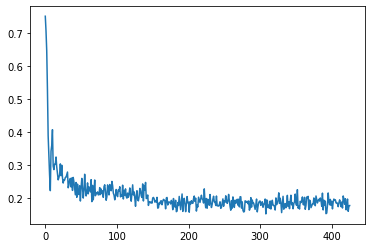

In [28]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [29]:
x_numerical_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [30]:
x_numerical_val, x_categorical_val, y_val = validation_ds.reverse_transform()

In [31]:
x_numerical_test, x_categorical_test, _ = test_ds.reverse_transform()

In [32]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [33]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

In [34]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

#### Training

In [35]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9274985557709933


In [36]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.9221214524638781


#### Validation

In [37]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8688560040958658


In [38]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.9042386624168205


#### Testing submission

In [39]:
#y_test_pred[:5]

In [40]:
submission = pd.DataFrame({
    'conversion': y_test_pred
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

,ROW_ID,conversion
19206,19206,0.0168
19207,19207,0.0595
19208,19208,0.0029
19209,19209,0.0680
19210,19210,0.0015


In [41]:
submission.to_csv('submission_2020_09_14.csv.gz', compression='gzip', index=False)